# Image Generation with IP-Adapter XL (SDXL)

This notebook demonstrates how to use the DEGIS package to:
1. Load trained color head models
2. Set up IP-Adapter XL with ControlNet for high-quality image generation
3. Generate images using color and layout control with SDXL

Based on the ablation notebook but using IP-Adapter XL for higher quality results.


## 1. Setup and Install Dependencies


In [1]:
# # Install IP-Adapter and dependencies
# %pip uninstall -y ip-adapter diffusers
# %pip install --no-cache-dir git+https://github.com/Ahmed-Sherif-ASA/IP-Adapter@main
# %pip install diffusers


## 2. Imports and Setup


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from IPython.display import display
import os
import glob

# Import the DEGIS package
import degis
from degis.data.dataset import UnifiedImageDataset
# from degis.config import csv_path, embeddings_path, colour_path, precomputed_adimagenet_edge_maps_path

# Import IP-Adapter XL
import ip_adapter
from ip_adapter import IPAdapterXL
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 3. Load Data and Models


In [3]:
csv_path = "/data/thesis/laion_5m_manifest.csv"
embeddings_path = "/data/thesis/models/hf_xl_laion_5m_embeddings.npy" # || YOUR_CUSTOM_PATH
colour_path = "/data/thesis/data/laion_5m_color_histograms_rgb_512.npy" # options: COLOR_HIST_PATH_LAB_514 || COLOR_HIST_PATH_RGB || YOUR_CUSTOM_PATH
colour_head_checkpoint_path = "/data/degis/runs/laion_5m_rgb512_tk20_b4096-20250904-234241/best_color_head_tmp.pth" # || YOUR_CUSTOM_PATH
precomputed_adimagenet_edge_maps_path = "/data/thesis/data/adimagenet_edge_maps.npy" # || YOUR_CUSTOM_PATH


# ip_ckpt = "/data/thesis/models/ip-adapter_sd15.bin"
image_encoder_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
controlnet_id = "diffusers/controlnet-canny-sdxl-1.0"
# stable_diffusion_model_id = "runwayml/stable-diffusion-v1-5"

In [4]:
# Load datasets
df = pd.read_csv(csv_path)
colour_dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# Load precomputed data
embeddings = np.load(embeddings_path, mmap_mode="r").astype(np.float32, copy=False)
histograms = np.load(colour_path, mmap_mode="r").astype(np.float32, copy=False)
edge_maps = np.load(precomputed_adimagenet_edge_maps_path, mmap_mode="r")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded histograms: {histograms.shape}")
print(f"Loaded edge maps: {edge_maps.shape}")

# Load trained color head
color_head = degis.load_trained_color_head(
    checkpoint_path=colour_head_checkpoint_path,
    clip_dim=embeddings.shape[1],
    hist_dim=histograms.shape[1],
    device=device
)
print("✓ Color head loaded successfully")


Loaded embeddings: (3336240, 1280)
Loaded histograms: (3336240, 512)
Loaded edge maps: (2080, 50176)
✓ Color head loaded successfully


## 4. Setup IP-Adapter XL Pipeline


In [5]:
# Setup cache directory
HF_CACHE = "/data/hf-cache" if os.path.exists("/data") else "./hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"] = os.path.join(HF_CACHE, "torch")

print(f"Using cache directory: {HF_CACHE}")

# Create IP-Adapter XL generator
generator = degis.IPAdapterXLGenerator(device=device)

# Setup the pipeline
generator.setup_pipeline(
    model_id="stabilityai/stable-diffusion-xl-base-1.0",
    controlnet_id=controlnet_id,
    ip_ckpt=None,  # Update path as needed
    image_encoder_path=image_encoder_path,
    cache_dir=HF_CACHE,
    torch_dtype=torch.float16,
)

print("✓ IP-Adapter XL pipeline setup complete")


Using cache directory: /data/hf-cache


Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IP-Adapter sdxl checkpoint not found at h94/IP-Adapter
✓ Downloaded IP-Adapter sdxl checkpoint


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ IP-Adapter XL pipeline setup complete


## 5. Image Generation Functions


In [6]:
def generate_from_dataset_id_xl(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    guidance_scale: float = 6.5,
    steps: int = 40,
    controlnet_conditioning_scale: float = 0.8,
    num_samples: int = 1,
    attn_ip_scale: float = 0.8,
    text_token_scale: float = 1.0,
    ip_token_scale: float = None,
    ip_uncond_scale: float = 0.0,
    zero_ip_in_uncond: bool = True,
):
    """Generate images using IP-Adapter XL with advanced controls."""
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = degis.get_color_embedding(color_head, z_clip)
    
    # Create control image from edge data
    control_image = degis.create_edge_control_image(edge_maps[layout_index], size=512)
    
    # Generate images with IP-Adapter XL
    images = generator.generate(
        color_embedding=color_embedding,
        control_image=control_image,
        prompt=prompt,
        negative_prompt=(
            "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
            "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
            "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
            "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
        ),
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        # IP-Adapter XL specific parameters
        attn_ip_scale=attn_ip_scale,
        text_token_scale=text_token_scale,
        ip_token_scale=ip_token_scale,
        ip_uncond_scale=ip_uncond_scale,
        zero_ip_in_uncond=zero_ip_in_uncond,
    )
    
    # Display results
    comparison = degis.display_comparison_grid(
        original=pil_img,
        control=control_image,
        generated=images,
        cols=3
    )
    display(comparison)
    
    return images

print("✓ IP-Adapter XL generation function defined")


✓ IP-Adapter XL generation function defined


## 6. Generate High-Quality Images


Generating images with IP-Adapter XL (SDXL)...


/tmp/ipykernel_911090/757691469.py:22: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)


  0%|          | 0/40 [00:00<?, ?it/s]

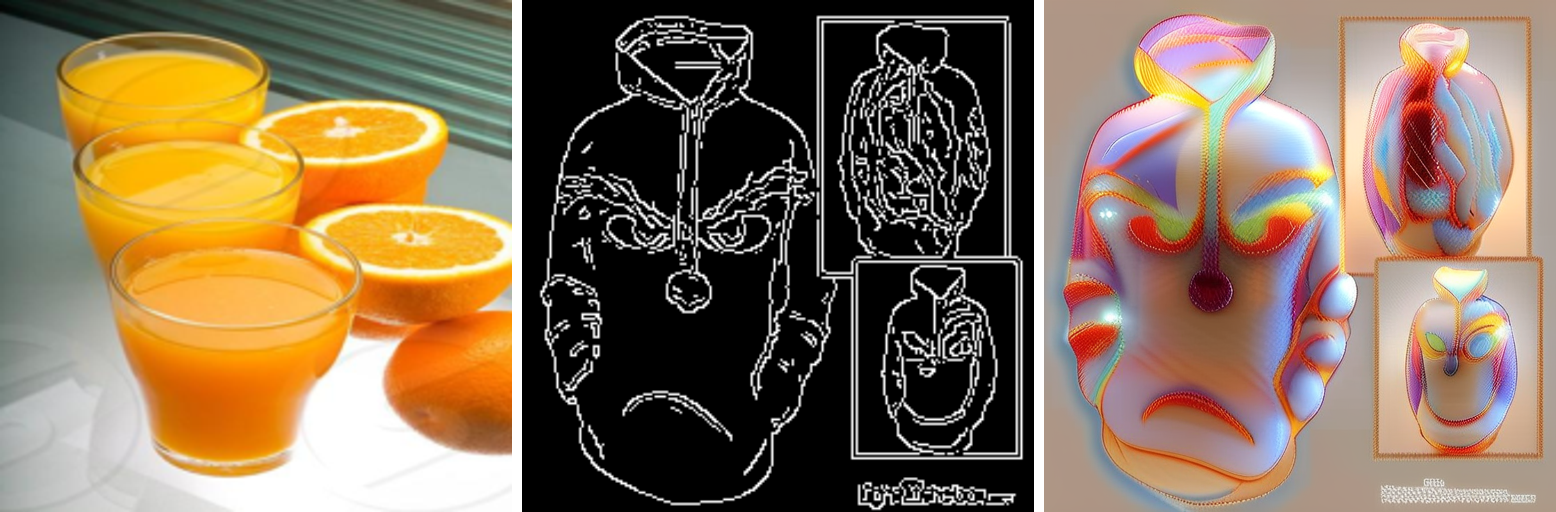

  0%|          | 0/50 [00:00<?, ?it/s]

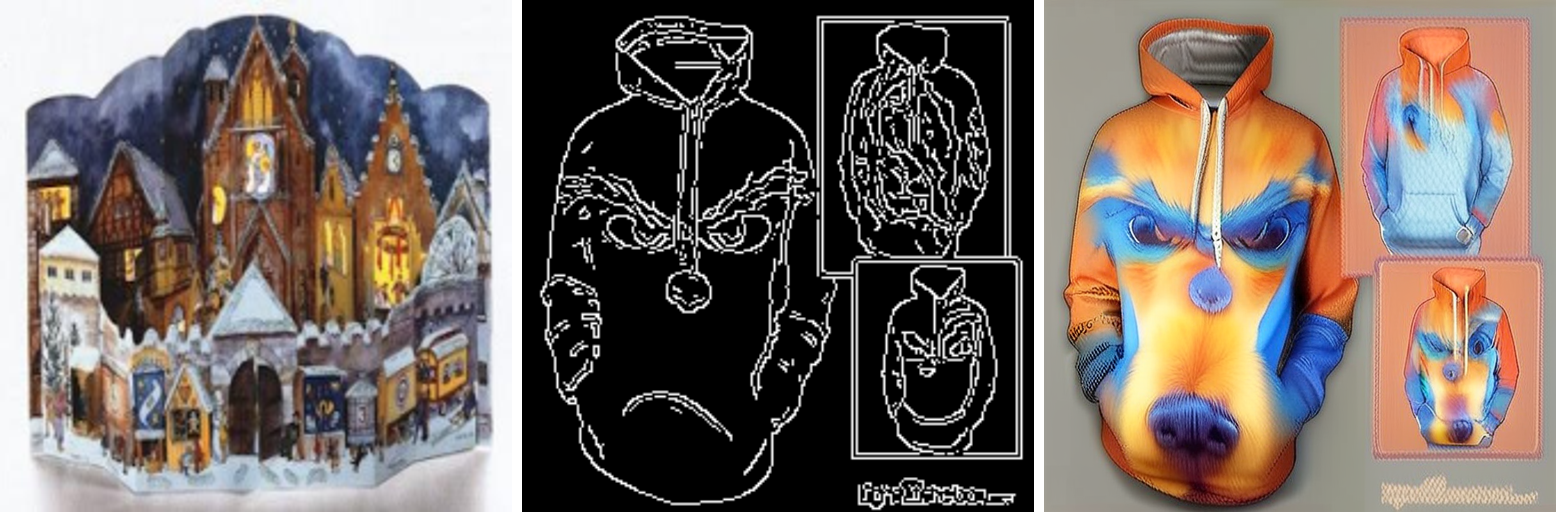

  0%|          | 0/60 [00:00<?, ?it/s]

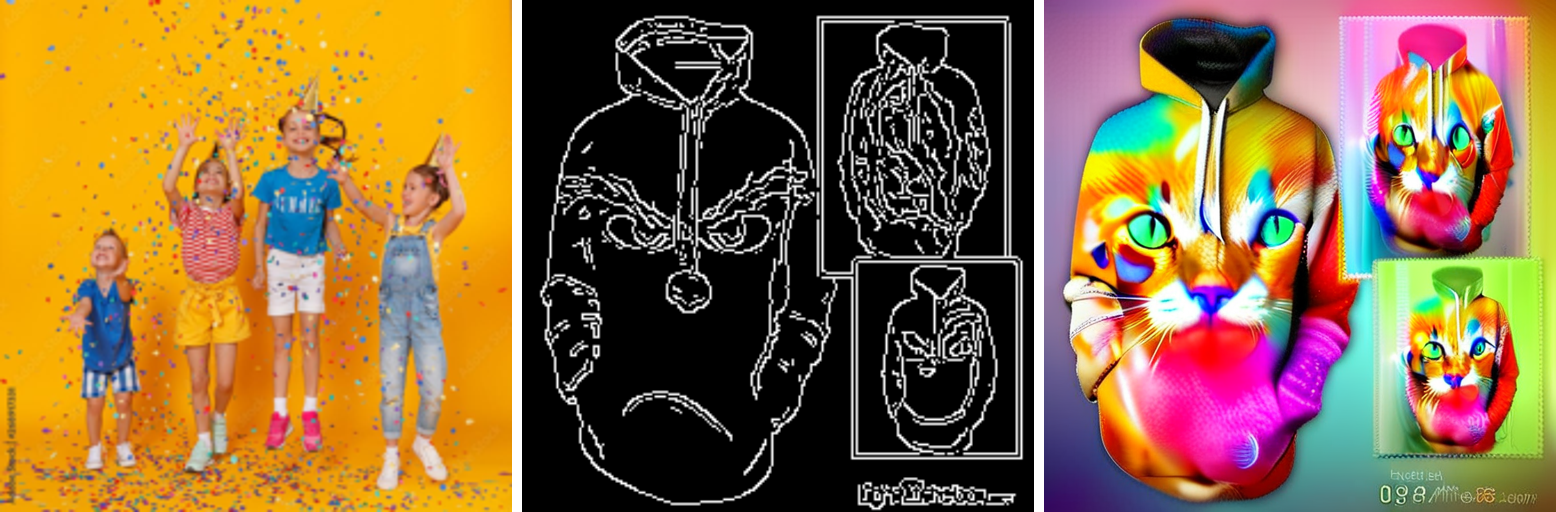

✓ High-quality image generation complete!


In [7]:
# Generate high-quality images with IP-Adapter XL
print("Generating images with IP-Adapter XL (SDXL)...")

# Example 1: Cat with ball (high quality)
images1 = generate_from_dataset_id_xl(
    colour_index=1000,
    layout_index=33,
    prompt="a cat playing with a ball, high quality, detailed",
    guidance_scale=6.5,
    steps=40,
    controlnet_conditioning_scale=0.8,
    num_samples=1,
    attn_ip_scale=0.8,
    text_token_scale=1.0,
    ip_token_scale=0.5,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

# Example 2: Dog on hoodie (artistic style)
images2 = generate_from_dataset_id_xl(
    colour_index=1008,
    layout_index=33,
    prompt="a dog on the hoodie, artistic style, professional photography",
    guidance_scale=7.5,
    steps=50,
    controlnet_conditioning_scale=0.9,
    num_samples=1,
    attn_ip_scale=0.6,
    text_token_scale=1.1,
    ip_token_scale=0.4,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

# Example 3: Creative composition
images3 = generate_from_dataset_id_xl(
    colour_index=1003,
    layout_index=33,
    prompt="A cat on the hoodie, digital art, vibrant colors, masterpiece",
    guidance_scale=8.0,
    steps=60,
    controlnet_conditioning_scale=0.7,
    num_samples=1,
    attn_ip_scale=0.7,
    text_token_scale=1.2,
    ip_token_scale=0.6,
    ip_uncond_scale=0.0,
    zero_ip_in_uncond=True,
)

print("✓ High-quality image generation complete!")
